# Appendix A: Lie Group Integrators

In any implementation of time-varying systems, thought must be given to numerical integration methods for finding approximate solutions to differential equations. Typical algorithms include Euler's Method and Runge-Kutta Methods (i.e., RK4). However, these classical algorithms are developed for use on flat Euclidean spaces and numerical instability issues can arise when applied to curvy manifolds such as the Lie groups relevant to robotics.

## Example in $S^1$
Consider the following motivating example. A pencil is spinning on a flat table. It's configuration space is $S^1$, which represents the space of possible $1$-dimensional orientations. The pencil's angular velocity is given by $\dot{\theta} = \omega(t)$, which we can measure using a nanometer-sized gyro with a sampling rate of $T_s=0.01$ seconds. Our objective is to use these angular velocity measurements to perform dead-reckoning and estimate the current angle of the pencil.

Let's first generate samples from the gyro on our spinning pencil. We assume that the pencil starts with some initial velocity that slowly decays over time.

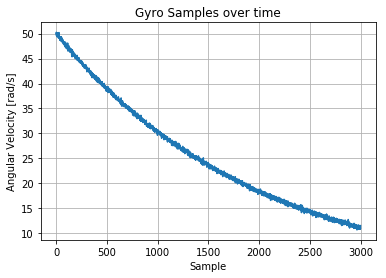

In [30]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def generate_gyro_samples(w0=50, Ts=0.01, secs=5, **kwargs):
    # number of samples
    N = int(secs/Ts)
    
    # sample time vector
    n = np.arange(N)

    # generate the slowly-decaying signal
    alpha = kwargs['alpha']
    w = w0*np.exp(-alpha*(n*Ts))
    
    # Make some noise!
    sigma = kwargs['sigma']
    eta = sigma*np.random.randn(N)
    
    return w + eta

# Simulation parameters
P = {
    # initial angular velocity
    'w0': 50,
    
    # sample period
    'Ts': 0.01,
    
    # duration of simulation
    'secs': 30,
    
    # exponential decay parameter
    'alpha': 0.05,
    
    # std dev of AWGN
    'sigma': 0.25
}

# Generate samples of gyro measurements
w = generate_gyro_samples(**P)
fig = plt.figure()
plt.plot(w)
plt.title('Gyro Samples over time')
plt.grid(); plt.xlabel('Sample'); plt.ylabel('Angular Velocity [rad/s]')
plt.show()

## Group Representation Class
To represent the orientation, which is an element of $S^1$, the following Python class is used. Internally, we use the uint-length complex number representation of group elements.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

class S1:
    def __init__(self, theta=0):
        # The representation of the group element
        self.z = self.from_algebra(theta)
        
        # Also store the original element of the algebra
        self.theta = theta
    
    def from_algebra(self, theta):
        return np.exp(1j*theta)
    
    def to_algebra(self, z):
        return np.imag(np.log(z))
    
    def visualize(self, trajectory=np.array([])):
        """Visualize the group element on its manifold
        :param trajectory: optional list of group elements to plot
        """
        fig = plt.figure(figsize=(7,7))

        n = np.linspace(0, 2*np.pi, 100)
        plt.plot(np.cos(n), np.sin(n))
        plt.axis('square'), plt.axis([-2, 2, -2, 2]), plt.axis('off')
        
        if not trajectory.size:
            trajectory = np.array([self.z])

        x, y = np.real(trajectory), np.imag(trajectory)
        plt.scatter(x, y, s=50, c='r')
        
        plt.show()

Using this class, we can visualize the current orientation of the pencil on the manifold $S^1$.

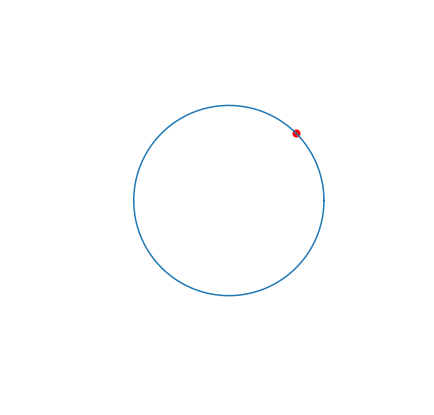

In [3]:
z = S1(theta=np.pi/4)
z.visualize()

## Kinematics
The kinematics that describe the evolution of the pencil's orientation on the manifold is given by the first-order differential equation

\begin{equation}
\dot{z} = f(z) = j \omega z,
\end{equation}

where $\theta \in \mathfrak{g} = \mathbb{R}$, $\dot{\theta} = \omega$ and $z \in \mathcal{G} = S^1$.

## Euler's Method
We would like to use a computer to approximate this ODE. A common numerical method for solving first-order ODEs is Euler's Method, an explicit algorithm which uses the limit definition of a derivative to find the update rule

\begin{align}
\frac{z(t+h)-z(t)}{h} &= j\omega z(t)\\
z(t+T_s) &= z(t)+h\omega z(t).
\end{align}

Assuming $\omega$ is constant in each sample interval and using $h=T_s$ (since that's when we have data to integrate), discretizing yields the digital algorithm

\begin{align}
z[n+1] &= z[n]+jT_s\omega[n] z[n]
\end{align}

In [4]:
class S1(S1):
    def euler_integration(self, w, Ts=0.01, secs=5, **kwargs):
        # convert seconds to steps
        steps = int(secs/Ts)
        
        # Store trajectory
        trajectory = np.zeros((steps+1,), dtype=complex)
        trajectory[0] = self.z

        for i in range(steps):
            self.z += Ts*( 1j*w[i]*self.z )
            trajectory[i+1] = self.z
            
        return trajectory

|z_final| = 3741967139783255876579586040129593354617930907648.0000


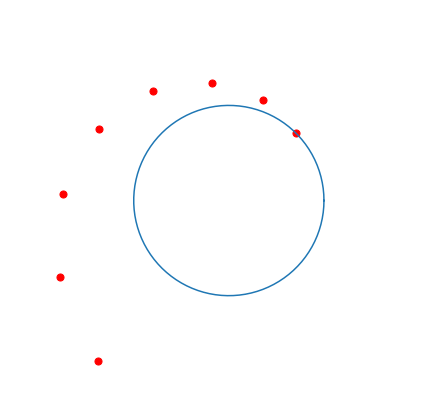

In [5]:
z = S1(theta=np.pi/4)
traj = z.euler_integration(w, **P)
print("|z_final| = {:.4f}".format(np.abs(traj[-1])))
z.visualize(traj)

The issue with this approach is that Euler's Method as it was implemented is only for Euclidean spaces. Note that the update steps calls for the addition of two group elements, which is not defined in $S^1$ and this scheme will cause the updated group element to lose the group property that $|z|=1$ and thus it will leave the manifold.

This is the core motivation for a study of Lie groups. Without the Lie group machinery, our estimation and control algorithms would suffer from numerical instability or costly normalization steps to reproject the updated value onto the manifold.

## Runge-Kutta 4 (RK4)
Of course, Euler's Method is a first-order, rough approximation of any differential equation -- even in Euclidean space. We can build a much stronger argument for the need of Lie group integrators by investigating the results of integrating the differential equation using the Euclidean RK4 method. The RK4 method is given by

\begin{align}
y_{n+1}	&=	y_{n}+\frac{h}{6}\left(k_{1}+2k_{2}+2k_{3}+k4\right) \\
t_{n+1}	&=	t_{n}+h
 \end{align}
 
where
 
\begin{align}
k_{1} &= f\left(t_{n},y_{n}\right) \\
k_{2} &= f\left(t_{n}+\frac{h}{2},y_{n}+\frac{h}{2}k_{1}\right) \\
k_{3} &= f\left(t_{n}+\frac{h}{2},y_{n}+\frac{h}{2}k_{2}\right) \\
k_{4} &= f\left(t_{n}+h,y_{n}+hk_{3}\right)
\end{align}

In [26]:
class S1(S1):
    def rk4_integration(self, w, Ts=0.01, secs=5, **kwargs):
        # convert seconds to steps
        steps = int(secs/Ts)
        
        # Store trajectory
        trajectory = np.zeros((steps+1,), dtype=complex)
        trajectory[0] = self.z
        
        f = lambda i, t, z: 1j*w[i]*z

        for i in range(steps):
            t = i*Ts
            k1 = f(i, t, self.z)
            k2 = f(i, t + Ts/2, self.z + Ts/2*k1)
            k3 = f(i, t + Ts/2, self.z + Ts/2*k2)
            k4 = f(i, t + Ts  , self.z + Ts  *k3)
            self.z += (Ts/6)*(k1 + 2*k2 + 2*k3 + k4)
            trajectory[i+1] = self.z

        return trajectory

|z_final| = 0.9652


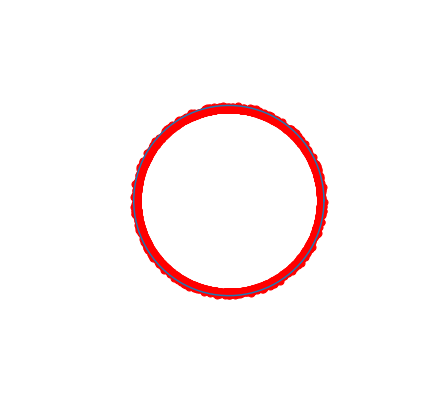

In [27]:
z = S1(theta=np.pi/4)
traj = z.rk4_integration(w, **P)
print("|z_final| = {:.4f}".format(np.abs(traj[-2])))
z.visualize(traj)

RK4 numerical integration does much better! But again, we can see that it breaks the constraint that $|z|=1$ and the updated elements eventually start leaving the manifold.

## Simple Lie Integrator
Instead of using classic numerical techniques to approximate the solution to the $S^1$ kinematic equation, instead we can analytically solve the ODE and then discretize to obtain a digital implementation. This makes us feel better since it is rooted in mathematical theory.

Noting that the kinematics

\begin{equation}
\dot{z} = f(z) = j \omega z,
\end{equation}

is of the form

\begin{equation}
\frac{dz}{dt} + p(t)z(t) = q(t)
\end{equation}

with $p(t)=-j \omega$ and $q(t) = 0$, we can use the integrating factor  $exp(-\int_{t_{0}}^{t}j\theta\left(\tau\right)d\tau)$ to find a solution that satisfies this differential equation.

Making no assumptions about the content of the continuous signal $\omega(t)$, and using the integrating factor, we can write the kinematics as

\begin{equation}
\left(\dot{z}-j\omega(t)z\right)e^{-\int_{t_{0}}^{t}j\omega\left(\tau\right)d\tau} = 0.
\end{equation}

Using the product rule, this becomes

\begin{equation}
\frac{d}{dt}\left[ze^{-\int_{t_{0}}^{t}j\omega\left(\tau\right)d\tau}\right]=0.
\end{equation}

Taking the integral of both sides with respect to time gives

\begin{equation}
\int_{t_{0}}^{t}\frac{d}{d\tau}\left[ze^{-\int_{t_{0}}^{\tau}j\omega\left(\sigma\right)d\sigma}\right]d\tau=0,
\end{equation}

for which we can use the Fundamental Theorem of Calculus to find the solution

\begin{align}
z(t)e^{-\int_{t_{0}}^{t}j\omega\left(\tau\right)d\tau}-z(t_{0})e^{-\int_{t_{0}}^{t_{0}}j\omega\left(\tau\right)d\tau}	&=	0 \\
z(t)	&=	z(t_{0})e^{\int_{t_{0}}^{t}j\omega(\tau)d\tau}.
\end{align}

### Digital Implementation: Zero-Order Hold
Because the gyro gives discrete samples every $T_s$ seconds, we need to discretize the solution for digital implementation. Let $t=nT_s$, $t_0=(n-1)T_s$ and use the notation $z[n]=z(nT_s)$. By using the concept of ZOH sampling, we assume that the signal is constant during the sample interval with $\omega[n]$. Therefore, $\int_{t_{0}}^{t}j\omega\left(\tau\right)d\tau=j\omega[n]T_{s}$ and

\begin{equation}
z[n]=z[n-1]e^{j\omega[n]T_{s}}
\end{equation}

In [8]:
class S1(S1):
    def lie_integration_zoh(self, w, Ts, secs=0, **kwargs):
        # convert seconds to steps
        steps = int(secs/Ts)
        
        # Store trajectory
        trajectory = np.zeros((steps+1,), dtype=complex)
        trajectory[0] = self.z
        
        for i in range(steps):
            self.z = self.z*np.exp(1j*w[i]*Ts)
            trajectory[i+1] = self.z
            
        return trajectory

|z_final| = 1.0000


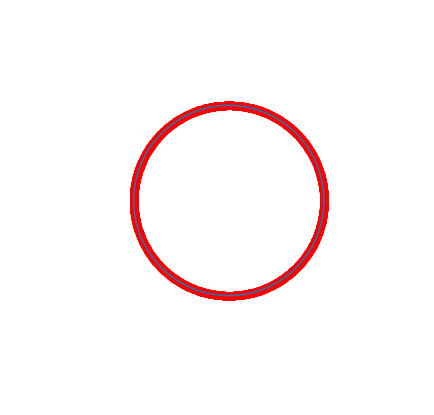

In [9]:
z = S1(theta=np.pi/4)
traj = z.lie_integration_zoh(w, **P)
print("|z_final| = {:.4f}".format(np.abs(traj[-1])))
z.visualize(traj)

Using the exponential mapping at each update, we see that the updated element stays on the manifold and maintains the geometric constraint $|z|=1$. Nice!

### Digital Implementation: Delayed First-Order Hold
To increase our accuracy (especially for slower sampling rates), we assume that the signal is changing linearly between samples and apply a FOH. Note that for this scheme to implemented causally, it introduces a one sample lag.